## Campaign exploratory data analysis 

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

campaign = pd.read_csv('data/campaign.csv')
campaign.drop('last_contact_date', axis=1, inplace=True)
client = pd.read_csv('data/client_modified.csv', usecols=['client_id', 'education', 'job', 'age_custom'])
print(campaign.info())
print()
print(client.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   client_id                   41188 non-null  int64
 1   number_contacts             41188 non-null  int64
 2   contact_duration            41188 non-null  int64
 3   previous_campaign_contacts  41188 non-null  int64
 4   previous_outcome            41188 non-null  bool 
 5   campaign_outcome            41188 non-null  bool 
dtypes: bool(2), int64(4)
memory usage: 1.3 MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   client_id   41188 non-null  int64 
 1   job         41188 non-null  object
 2   education   41188 non-null  object
 3   age_custom  41183 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.3+ MB
N

In [11]:
# Merge the datasets and columns needed, set the outcomes as Success or Failure
merged = campaign.merge(client, on='client_id', how='inner')
merged['campaign_outcome'] = merged['campaign_outcome'].apply(lambda x: 'Success' if x==1 else 'Failure')
merged['previous_outcome'] = merged['previous_outcome'].apply(lambda x: 'Success' if x==1 else 'Failure')

# Change contact duration to minutes
merged['contact_duration'] = merged['contact_duration'] / 60

# Set age bins as categories
labels = ['17-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-98']
merged['age_custom'] = pd.Categorical(merged['age_custom'], labels, ordered=True)

# Capitalize categorical columns
cat_cols = merged.select_dtypes(include='object').columns
for col in cat_cols:
    merged[col] = merged[col].str.capitalize()

print(merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   client_id                   41188 non-null  int64   
 1   number_contacts             41188 non-null  int64   
 2   contact_duration            41188 non-null  float64 
 3   previous_campaign_contacts  41188 non-null  int64   
 4   previous_outcome            41188 non-null  object  
 5   campaign_outcome            41188 non-null  object  
 6   job                         41188 non-null  object  
 7   education                   41188 non-null  object  
 8   age_custom                  41183 non-null  category
dtypes: category(1), float64(1), int64(3), object(4)
memory usage: 2.6+ MB
None


There are 41,118 observations. The distributions of interest are left-skewed, so the median is a more appropriate measure of central tendency than the mean. The number of contacts is measured in attempts: the median for the current campaign is 2, and for the previous campaign, it is 0. The median contact duration for the current campaign is 3 minutes.

It's also possible to infer the presence of outliers in both number of contacts and contact duration by examining the summary statistics and their distributions. For example, the 75th percentile for number of contacts is 3 attempts, but the maximum is 56. A similar pattern is seen with contact duration: the 75th percentile is 5.32 minutes, while the maximum is 81.97 minutes.

       number_contacts  contact_duration  previous_campaign_contacts
count         41188.00          41188.00                    41188.00
mean              2.57              4.30                        0.17
std               2.77              4.32                        0.49
min               1.00              0.00                        0.00
25%               1.00              1.70                        0.00
50%               2.00              3.00                        0.00
75%               3.00              5.32                        0.00
max              56.00             81.97                        7.00


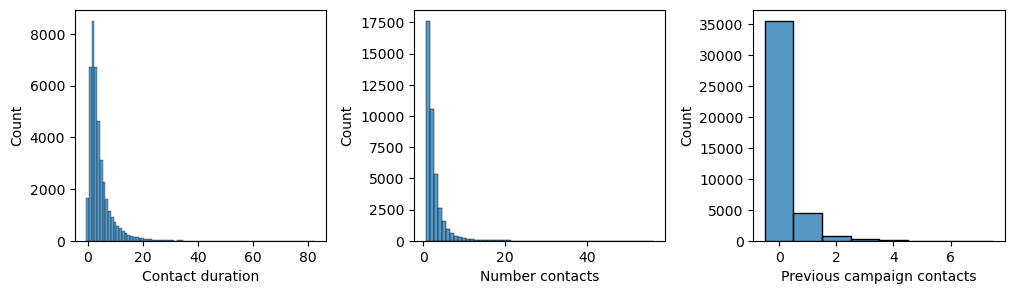

In [12]:
# Summary stats for numeric variables
summary = merged.drop('client_id', axis=1).describe().round(2)
print(summary)

# Numeric variables ditribution
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

cols = ['contact_duration', 'number_contacts', 'previous_campaign_contacts']
for i, col in enumerate(cols):
    ax[i].set_xlabel(col.replace('_', ' ').capitalize())
    sns.histplot(merged[col], bins=30, discrete=True, ax=ax[i])

plt.subplots_adjust(wspace=0.35)
plt.show()

The proportion of failures in both campaigns is high, but there has been a notable improvement in the current one. In the previous campaign, only 3.3% of contact attempts were labeled as Success, whereas in the current campaign, this category has more than tripled, rising to 11.3%. This suggests that the current strategy or conditions may be more effective in achieving successful contacts.

result    Failure  Success
campaign                  
Current     0.887    0.113
Previous    0.967    0.033


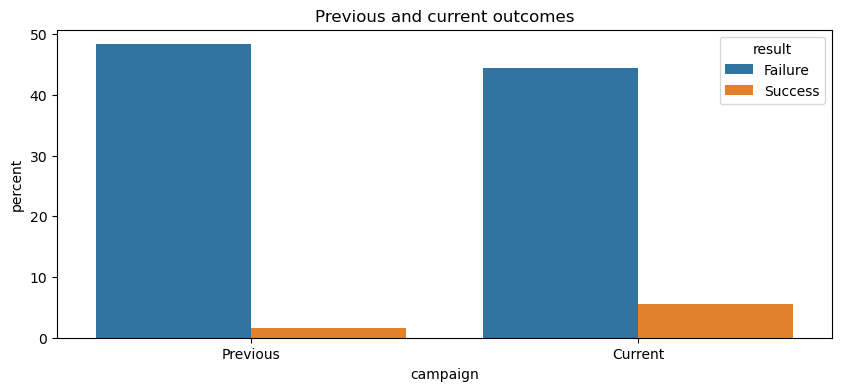

In [13]:
# Previous and current outcomes
df = pd.melt(merged,
             id_vars=['client_id'],
             value_vars=['previous_outcome','campaign_outcome'],
             var_name='campaign',
             value_name='result')

df['campaign'] = df['campaign'].apply(lambda x: 'Previous' if x == 'previous_outcome' else 'Current')

# Calculate the proportion for each campaign and result
pivot_table = pd.pivot_table(df, values='client_id', index='campaign', columns='result', aggfunc='count', observed=True)
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0).round(3)
print(pivot_table_percentage)

# Previous and current outcomes plot
plt.figure(figsize=(10, 4))
plt.title('Previous and current outcomes')
sns.countplot(x='campaign', hue='result', stat='percent', data=df)
plt.show()

## Current campaign

The boxplot shows a large number of outliers in contact duration, which are values that lie beyond the upper whisker of the distribution. Interestingly, many of these outliers are clustered between 10 and 30 minutes. This suggests that while these durations are statistically distant from the bulk of the data, they are not rare occurrences. Instead, they represent a concentration of relatively longer contact times that may carry practical significance, especially when evaluating efficiency or customer engagement in the campaign.

Median contact duration in minutes: 3.0
Mean contact duration in minutes: 4.3


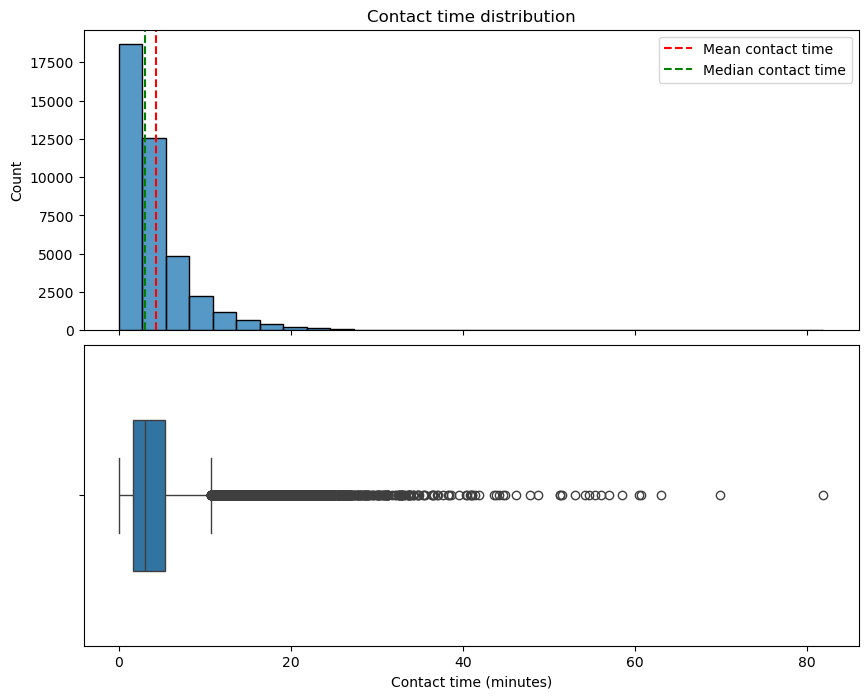

In [14]:
# Median and mean contact duration
median = merged['contact_duration'].median()
mean = merged['contact_duration'].mean()
print(f'Median contact duration in minutes: {median}')
print(f'Mean contact duration in minutes: {round(mean, 2)}')

# Contact time distribution
fig, ax = plt.subplots(nrows=2, figsize=(10, 8), sharex=True)

ax[0].set_title('Contact time distribution')
sns.histplot(x='contact_duration', data=merged, bins=30, ax=ax[0])
ax[0].axvline(mean, color='red', linestyle='--', label='Mean contact time')
ax[0].axvline(median, color='green', linestyle='--', label='Median contact time')

ax[1].set_xlabel('Contact time (minutes)')
sns.boxplot(x='contact_duration', data=merged, width=0.5, ax=ax[1])

ax[0].legend()
plt.subplots_adjust(hspace=0.05)
plt.show()

An interesting finding is that the median contact duration is higher across all age categories when the outcome is a success, compared to failures, which tend to take fewer minutes. If we interpret this as a sign of customer engagement, we can say that clients aged 35–44 are willing to engage in longer conversations and still have a high chance of a successful outcome. A similar pattern is observed in the 25–34, 45–54, and 55–64 age groups. In contrast, the remaining age categories tend to have shorter median contact times.

Another noteworthy pattern appears when looking at the median contact duration for each age group in cases of failure. These values are remarkably consistent, varying by only about 6 seconds from the lowest (2.61 minutes) to the highest (2.70 minutes).

age_custom        17-24  25-34  35-44  45-54  55-64  65-74  75-98
campaign_outcome                                                 
Failure            2.69   2.70   2.78   2.70   2.65   2.63   2.61
Success            5.82   7.65   9.22   8.27   6.52   4.72   4.80


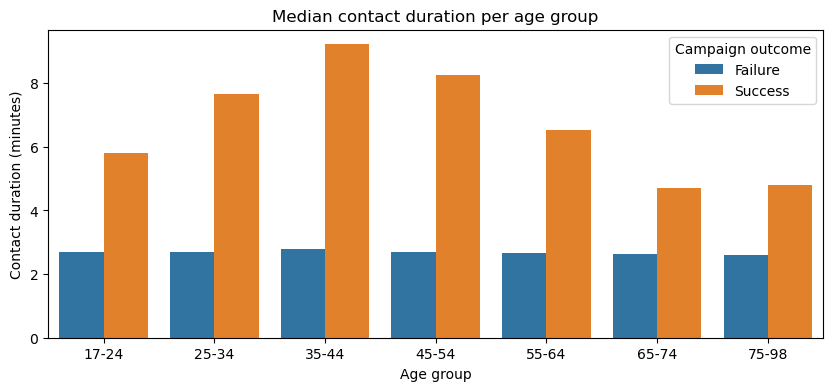

In [15]:
# Median contact duration by age group and campaign outcome
pivot = pd.pivot_table(merged,
                       index='campaign_outcome',
                       columns='age_custom', 
                       values='contact_duration',
                       aggfunc='median',
                       observed=False).round(2)
print(pivot)

plt.figure(figsize=(10, 4))
plt.title('Median contact duration per age group')
plt.xlabel('Age group'); plt.ylabel('Contact duration (minutes)')
sns.barplot(x='age_custom', y='contact_duration', hue='campaign_outcome', estimator='median', errorbar=None, data=merged)
plt.legend(title='Campaign outcome')
plt.show()

The boxpot of contact attempt shows the presence of outliers. Although the data points are not as clutered as in the previous case involving contact time, a small group appears in the range from 7 to 20.

Median contact attempt: 2.0
Mean contact attempt: 2.57


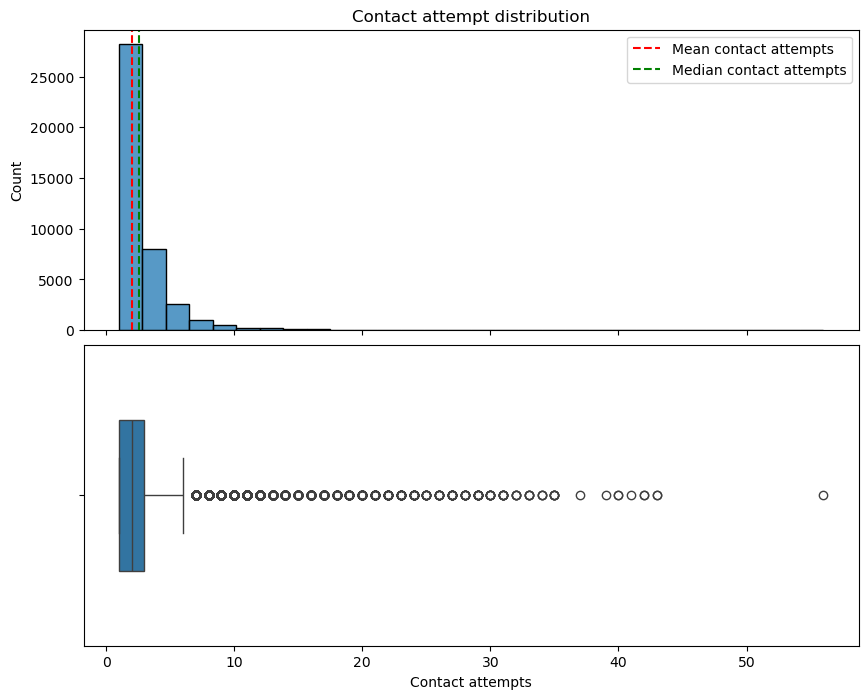

In [16]:
# Median and mean of contact attempts
median = merged['number_contacts'].median()
mean = merged['number_contacts'].mean()
print(f'Median contact attempt: {median}')
print(f'Mean contact attempt: {round(mean, 2)}')

# Contact attempt distribution
fig, ax = plt.subplots(nrows=2, figsize=(10, 8), sharex=True)

ax[0].set_title('Contact attempt distribution')
sns.histplot(x='number_contacts', data=merged, bins=30, ax=ax[0])
ax[0].axvline(median, color='red', linestyle='--', label='Mean contact attempts')
ax[0].axvline(mean, color='green', linestyle='--', label='Median contact attempts')

sns.boxplot(x='number_contacts', width=0.5, data=campaign, ax=ax[1])
ax[1].set_xlabel('Contact attempts')

ax[0].legend()
plt.subplots_adjust(hspace=0.05)
plt.show()

When examining the median number of contact attempts across all age categories, some groups required only one attempt to achieve a successful contact. These groups include customers aged 17-24, 35-44, 65-74, and 75-98. An analysis of this type of success, or 'instant success', would be valuable.

age_custom        17-24  25-34  35-44  45-54  55-64  65-74  75-98
campaign_outcome                                                 
Failure             2.0    2.0    2.0    2.0    2.0    2.0    1.0
Success             1.0    2.0    1.0    2.0    2.0    1.0    1.0


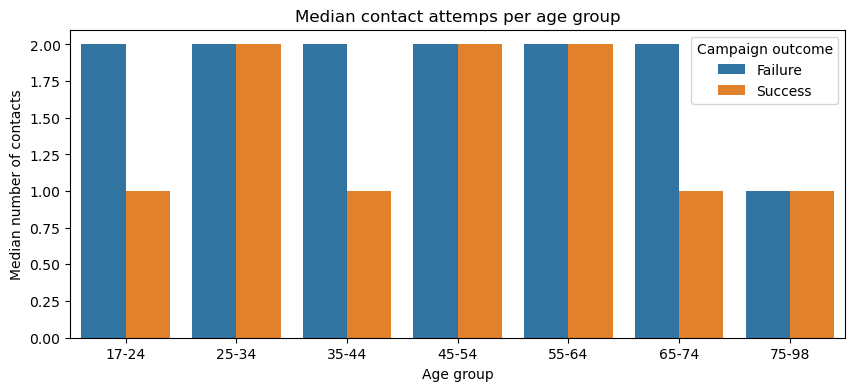

In [17]:
# Median contact attemps per age group
pivot = pd.pivot_table(merged,
                       index='campaign_outcome',
                       columns='age_custom',
                       values='number_contacts',
                       aggfunc='median',
                       observed=False)
print(pivot)

plt.figure(figsize=(10, 4))
plt.title('Median contact attemps per age group')
plt.xlabel('Age group'); plt.ylabel('Median number of contacts')
sns.barplot(x='age_custom', y='number_contacts', hue='campaign_outcome', estimator='median', errorbar=None, data=merged)
plt.legend(title='Campaign outcome')
plt.show()

## Instant success
The analysis uses three categories —age range, job, and education— after filtering the data to include only records with a single contact attempt and a successful outcome. These categories are measured as proportions shown in bar charts, meaning each bar represents the proportion of a given category relative to all observations.

In [18]:
# Instant success
min_cont = merged.query('number_contacts == 1 & campaign_outcome == "Success"')
print('Number of users with just 1 contact:', len(min_cont))
print(min_cont.info())

Number of users with just 1 contact: 2300
<class 'pandas.core.frame.DataFrame'>
Index: 2300 entries, 75 to 41186
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   client_id                   2300 non-null   int64   
 1   number_contacts             2300 non-null   int64   
 2   contact_duration            2300 non-null   float64 
 3   previous_campaign_contacts  2300 non-null   int64   
 4   previous_outcome            2300 non-null   object  
 5   campaign_outcome            2300 non-null   object  
 6   job                         2300 non-null   object  
 7   education                   2300 non-null   object  
 8   age_custom                  2299 non-null   category
dtypes: category(1), float64(1), int64(3), object(4)
memory usage: 164.3+ KB
None


When observing instant success by age range, the highest proportion comes from customers aged 25-34, accounting for 37%. The next most significant groups are 35-44 and 45-54, with 24% and 15%, respectively.

age_custom        17-24  25-34  35-44  45-54  55-64  65-74  75-98
campaign_outcome                                                 
Success            0.08   0.37   0.24   0.15   0.09   0.04   0.03


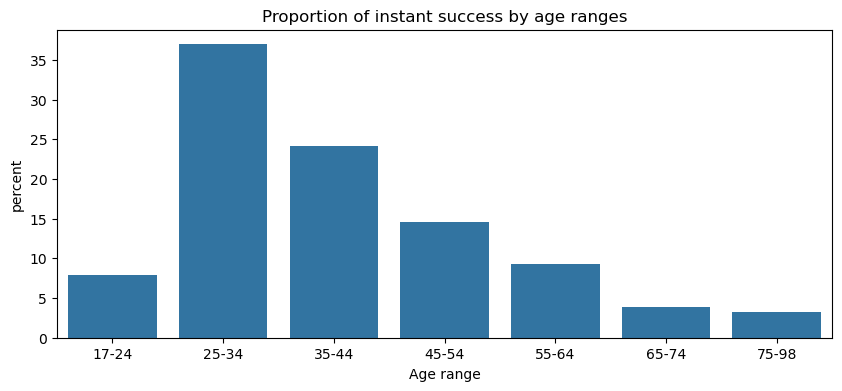

In [19]:
# Proportion of instant success by age ranges
pivot = pd.pivot_table(min_cont,
                       index='campaign_outcome',
                       columns='age_custom',
                       values='client_id',
                       aggfunc='count',
                       observed=False)

pivot_table_percentage = pivot.div(pivot.sum(axis=1), axis=0).round(2)
print(pivot_table_percentage)

plt.figure(figsize=(10, 4))
plt.title('Proportion of instant success by age ranges')
plt.xlabel('Age range')
sns.countplot(x='age_custom', data=min_cont, stat='percent')
plt.show()

The job categories with the highest proportions of instant success are admin, technician, and blue-collar, with 30%, 16%, and 13%, respectively.

job               Admin  Blue-collar  Entrepreneur  Housemaid  Management  \
campaign_outcome                                                            
Success             0.3         0.13          0.03       0.02        0.07   

job               Retired  Self-employed  Services  Student  Technician  \
campaign_outcome                                                          
Success               0.1           0.03      0.06     0.06        0.16   

job               Unemployed  Unknown  
campaign_outcome                       
Success                 0.03     0.01  


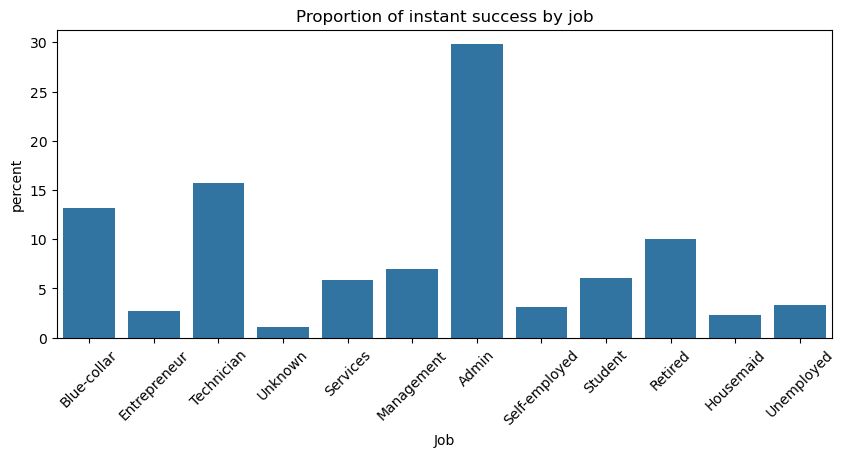

In [20]:
# Proportion of instant success by job
pivot = pd.pivot_table(min_cont,
                       index='campaign_outcome',
                       columns='job',
                       values='client_id',
                       aggfunc='count',
                       observed=False)

pivot_table_percentage = pivot.div(pivot.sum(axis=1), axis=0).round(2)
print(pivot_table_percentage)

plt.figure(figsize=(10, 4))
plt.title('Proportion of instant success by job')
plt.xlabel('Job')
plt.xticks(rotation=45)
sns.countplot(x='job', data=min_cont, stat='percent')
plt.show()

In terms of education, the most representative categories are university degree, high school, and professional course, with 37%, 22%, and 13%, respectively.

education         Basic 4y  Basic 6y  Basic 9y  High school  Illiterate  \
campaign_outcome                                                          
Success                0.1      0.03       0.1         0.22         0.0   

education         Professional course  University degree  Unknown  
campaign_outcome                                                   
Success                          0.13               0.37     0.06  


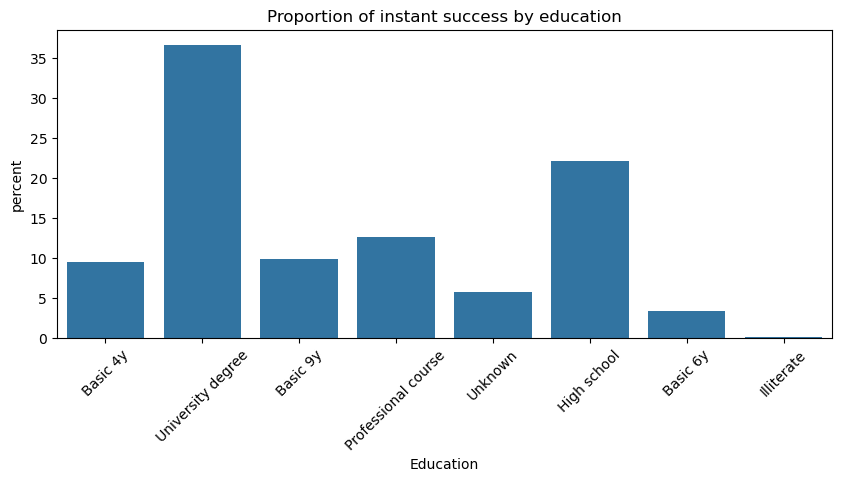

In [21]:
# Proportion of instant success by education
pivot = pd.pivot_table(min_cont,
                       index='campaign_outcome',
                       columns='education',
                       values='client_id',
                       aggfunc='count',
                       observed=False)

pivot_table_percentage = pivot.div(pivot.sum(axis=1), axis=0).round(2)
print(pivot_table_percentage)

plt.figure(figsize=(10, 4))
plt.title('Proportion of instant success by education')
plt.xlabel('Education')
plt.xticks(rotation=45)
sns.countplot(x='education', data=min_cont, stat='percent')
plt.show()